# **Value At Risk**

# Fonction permettant de compute la VaR de manière robuste : Historical VaR, Parametric VaR et Monte Carlo VaR



In [15]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

In [3]:
# Fonction de calcul la VaR

class VaR:
    

    
    def __init__(self, ticker, start_date, end_date, rolling_window, confidence_level, portfolio_val,simulations):
        
        self.ticker = ticker
        self.start = start_date
        self.end = end_date
        self.rolling = rolling_window
        self.conf_level = confidence_level
        self.portf_val = portfolio_val
        self.simulations = simulations
        
        self.data()
        self.historical_method()
        self.parametric_method()
        self.montecarlo_method()
        
        
        
    def data(self):
        df = yf.download(self.ticker, self.start, self.end)
        self.adj_close_df = df["Adj Close"]
        self.log_returns_df = np.log(self.adj_close_df/self.adj_close_df.shift(1))
        self.log_returns_df = self.log_returns_df.dropna()
        self.equal_weights = np.array([1/len(self.ticker)]*len(self.ticker))
        historical_returns = (self.log_returns_df*self.equal_weights).sum(axis=1)
        self.rolling_returns = historical_returns.rolling(window = self.rolling).sum()
        self.rolling_returns = self.rolling_returns.dropna()    # Portfolio Returns   
        
        
    def historical_method(self):
        
        historical_VaR = -np.percentile(self.rolling_returns, 100 - (self.conf_level*100)) * self.portf_val
        self.returns_dollar =  self.rolling_returns * self.portf_val
        
        plt.hist(self.returns_dollar, bins=50, density=True)
        plt.xlabel(f' \n Historical_VaR = ${historical_VaR:.2f}')
        plt.ylabel('Frequency')
        plt.title(f"Distribution of Portfolio's {self.rolling} - Day Returns \n (Historical VaR)")
        plt.axvline(-historical_VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {self.conf_level:.0%} confidence level')
        plt.legend()
        plt.show()
        
        
    def parametric_method(self):
        self.cov_matrix = self.log_returns_df.cov() * 252
        self.portfolio_std = np.sqrt(self.equal_weights.T @ self.cov_matrix @ self.equal_weights)
        
        parametric_VaR = self.portfolio_std * norm.ppf(self.conf_level) * np.sqrt(self.rolling / 252) * self.portf_val
        
        
        plt.hist(self.returns_dollar, bins=50, density=True)
        plt.xlabel(f' \n Parametric_VaR = ${parametric_VaR:.2f}')
        plt.ylabel('Frequency')
        plt.title(f'(Parametric VaR)')
        plt.axvline(-parametric_VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {self.conf_level:.0%} confidence level')
        plt.legend()
        plt.show()

        
    def montecarlo_method(self):
        
        def expected_return(weights, log_returns):
            return np.sum(log_returns.mean()*weights)
        
        def standard_deviation (weights, cov_matrix):
            variance = weights.T @ cov_matrix @ weights
            return np.sqrt(variance)

        self.cov_matrix_1 = self.log_returns_df.cov()
        portfolio_expected_return = expected_return(self.equal_weights, self.log_returns_df)
        portfolio_std_dev = standard_deviation (self.equal_weights, self.cov_matrix_1)
        
        def random_z_score():
            return np.random.normal(0, 1)

        def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
            return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

        scenarioReturn = []

        for i in range(self.simulations):
            z_score = random_z_score()
            scenarioReturn.append(scenario_gain_loss(self.portf_val, portfolio_std_dev, z_score, self.rolling))
            
        montecarlo_VaR = -np.percentile(scenarioReturn, 100 * (1 - self.conf_level))
        
        plt.hist(scenarioReturn, bins=50, density=True)
        plt.xlabel(f' \n Montecarlo_VaR = ${montecarlo_VaR:.2f}')
        plt.ylabel('Frequency')
        plt.title(f'(Montecarlo VaR)')
        plt.axvline(-montecarlo_VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {self.conf_level:.0%} confidence level')
        plt.legend()
        plt.show()
 

In [5]:
import nbimporter
from VaRcalculator import VaR

[*********************100%%**********************]  5 of 5 completed


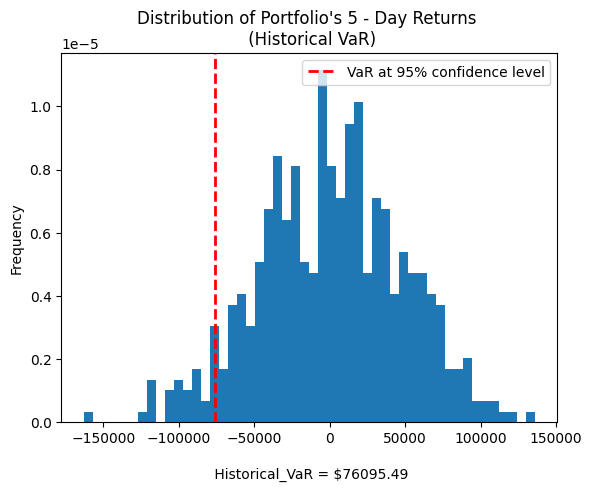

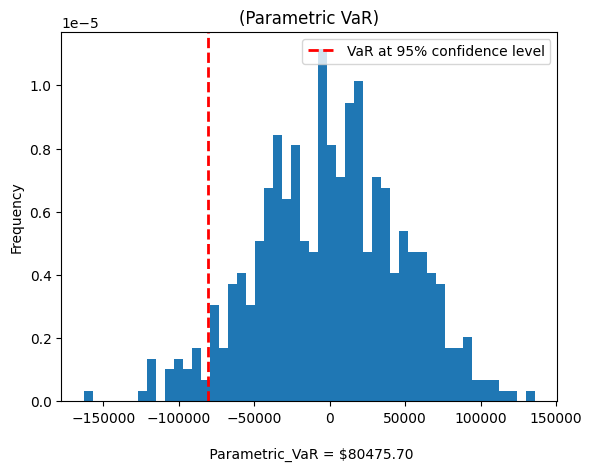

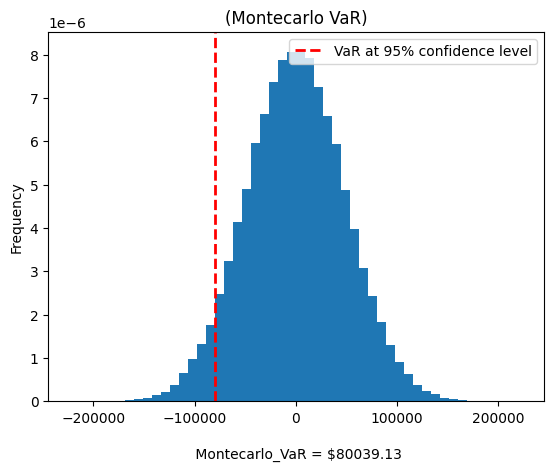

In [16]:
tickers = ["NVDA", "AAPL", "TSLA", "QQQ", "MSFT"] #titre detenu dans le portefeuille

df = VaR(
    ticker=tickers, 
    start_date='2022-01-01', #période de détention des titres
    end_date='2024-01-01', 
    rolling_window=5, 
    confidence_level=0.95, #intervalle de confiance 
    portfolio_val=1000000, 
    simulations=100000) #steps